# Protein Structural Change Prediction Example
In this notebook, we use Graphein to preprocess the PSCDB database into graphs. We then perform graph classification on the unbound protein ligand graphs to predict the class of structural rearrangement the protein undergoes upon ligand binding.

In [133]:
import dgl
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm
from dgllife.model.model_zoo import GCNPredictor
from graphein.construct_graphs import ProteinGraph
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, precision_score, recall_score
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

from matplotlib import pyplot as plt
device = 'cpu'

## Data
1.  We load the dataset. The script for parsing the datafrom a webserver to the `structural_rearrangement_data.csv` file is available in `process_data.ipynb` and `make_rearrangement_data.py` 

In [24]:
# Load data sets
df = pd.read_csv('structural_rearrangement_data.csv')
df.head()

,Unnamed: 0,level_0,index,PSCID,Protein Name,Free form,Bound form,Ligands,Classification(?),motion_type,Free PDB,Free Chains,Bound PDB,Bound Chains
0,0,0,0,CD.1,HYPOTHETICAL OXIDOREDUCTASE YIAK,1nxu_AB,1s20_AB,"2xNAD,2xTLA",200004,coupled_domain_motion,1nxu,AB,1s20,AB
1,1,1,1,CD.2,ADENYLATE KINASE,4ake_A,2eck_A,"ADP,AMP",200003,coupled_domain_motion,4ake,A,2eck,A
2,2,2,2,CD.3,GLUCOKINASE,1q18_AB,1sz2_AB,2xBGC,200003,coupled_domain_motion,1q18,AB,1sz2,AB
3,3,3,3,CD.4,LACTOFERRIN,1lfh_A,1lfi_A,"2xCU,2xNAG",110103,coupled_domain_motion,1lfh,A,1lfi,A
4,4,4,4,CD.5,ELONGATION FACTOR 2,1n0v_D,1n0u_A,SO1,110002,coupled_domain_motion,1n0v,D,1n0u,A


2. We create one-hot encodings of the labels, indicating the rearrangement motion class

In [63]:
# Create labels
labels = pd.get_dummies(df.motion_type).values.tolist()
labels = [torch.Tensor(i) for i in labels]

tensor([0., 1., 0., 0., 0., 0., 0.])

3. We split the data into training and testing data, and construct the Graphs using Graphein. 

Graphein will automatically download the relevant `.PDB` files from the PDB and compute the intramolecular contacts using `GetContacts` if the files are not found in the `pdb_dir` and `contacts_dir` directories.

We select the relevant chains in structure from the PDB from the `Free Chains` column in the dataframe.

In [38]:
# Split datasets
x_train, x_test, y_train, y_test = train_test_split(df, labels, test_size=0.15)

# Initialise Graph Constructor
pg = ProteinGraph(granularity='CA', insertions=False, keep_hets=True,
                  node_featuriser='meiler', get_contacts_path='/Users/arianjamasb/github/getcontacts',
                  pdb_dir='../../examples/pdbs/',
                  contacts_dir='../../examples/contacts/',
                  exclude_waters=True, covalent_bonds=False, include_ss=True)

# Build Graphs
train_graphs = [pg.dgl_graph_from_pdb_code(pdb_code=x_train['Free PDB'].iloc[i],
                                         chain_selection=list(x_train['Free Chains'].iloc[i])) for i in tqdm(range(len(x_train)))]

test_graphs = [pg.dgl_graph_from_pdb_code(pdb_code=x_test['Free PDB'].iloc[i],
                                         chain_selection=list(x_test['Free Chains'].iloc[i])) for i in tqdm(range(len(x_test)))]




  0%|          | 0/134 [00:00<?, ?it/s]


  1%|          | 1/134 [00:00<00:14,  8.88it/s]

Detected 16 HETATOM nodes
Detected 93 total nodes
Contact file found: ['../../examples/contacts/2bl7_contacts.tsv']
Calculated 234 intramolecular interaction-based edges
DGLGraph(num_nodes=93, num_edges=234,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 1 HETATOM nodes
Detected 445 total nodes
Contact file found: ['../../examples/contacts/2fs5_contacts.tsv']
Calculated 1217 intramolecular interaction-based edges





  1%|▏         | 2/134 [00:00<00:17,  7.42it/s]


  2%|▏         | 3/134 [00:00<00:19,  6.86it/s]

DGLGraph(num_nodes=445, num_edges=1217,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 1 HETATOM nodes
Detected 362 total nodes
Contact file found: ['../../examples/contacts/1so7_contacts.tsv']
Calculated 895 intramolecular interaction-based edges
DGLGraph(num_nodes=362, num_edges=895,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa'




  3%|▎         | 4/134 [00:00<00:22,  5.67it/s]

Detected 10 HETATOM nodes
Detected 889 total nodes
Contact file found: ['../../examples/contacts/2c00_contacts.tsv']
Calculated 1181 intramolecular interaction-based edges
DGLGraph(num_nodes=445, num_edges=1181,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})





  4%|▎         | 5/134 [00:00<00:26,  4.85it/s]

Detected 25 HETATOM nodes
Detected 808 total nodes
Contact file found: ['../../examples/contacts/1usl_contacts.tsv']
Calculated 958 intramolecular interaction-based edges
DGLGraph(num_nodes=322, num_edges=958,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})





  4%|▍         | 6/134 [00:01<00:24,  5.17it/s]

Detected 11 HETATOM nodes
Detected 381 total nodes
Contact file found: ['../../examples/contacts/2dcz_contacts.tsv']
Calculated 459 intramolecular interaction-based edges
DGLGraph(num_nodes=185, num_edges=459,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 53 HETATOM nodes
Detected 220 total nodes
Contact file found: ['../../examples/contacts/2znd_contacts.tsv']
Calculated 485 intramolecular interaction-based edges





  5%|▌         | 7/134 [00:01<00:21,  5.82it/s]

DGLGraph(num_nodes=440, num_edges=485,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 269 HETATOM nodes
Detected 1572 total nodes
Contact file found: ['../../examples/contacts/3c8n_contacts.tsv']





  6%|▌         | 8/134 [00:01<00:29,  4.32it/s]

Calculated 2122 intramolecular interaction-based edges
DGLGraph(num_nodes=798, num_edges=2122,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Downloaded PDB file for: 1ll3
Detected 12 HETATOM nodes
Detected 273 total nodes
1ll3
['../../examples/pdbs/1ll3.pdb']
PDB file detected: ../../examples/pdbs/1ll3.pdb





  7%|▋         | 9/134 [00:04<01:53,  1.11it/s]

Computed Contacts for: 1ll3
Calculated 736 intramolecular interaction-based edges
DGLGraph(num_nodes=546, num_edges=736,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})





  7%|▋         | 10/134 [00:04<01:30,  1.37it/s]

Detected 5 HETATOM nodes
Detected 959 total nodes
Contact file found: ['../../examples/contacts/2iw2_contacts.tsv']
Calculated 2904 intramolecular interaction-based edges
DGLGraph(num_nodes=959, num_edges=2904,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})





  8%|▊         | 11/134 [00:04<01:10,  1.76it/s]

Detected 0 HETATOM nodes
Detected 482 total nodes
Contact file found: ['../../examples/contacts/1smn_contacts.tsv']
Calculated 1281 intramolecular interaction-based edges
DGLGraph(num_nodes=482, num_edges=1281,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 5 HETATOM nodes
Detected 246 total nodes
Contact file found: ['../../examples/contacts/1ywf_contacts.tsv']
Calculated 722 intramolecular interaction-based edges





  9%|▉         | 12/134 [00:04<00:53,  2.27it/s]

DGLGraph(num_nodes=246, num_edges=722,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 10 HETATOM nodes
Detected 1452 total nodes





 10%|▉         | 13/134 [00:05<00:51,  2.33it/s]

Contact file found: ['../../examples/contacts/2brw_contacts.tsv']
Calculated 2043 intramolecular interaction-based edges
DGLGraph(num_nodes=726, num_edges=2043,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})





 10%|█         | 14/134 [00:05<00:47,  2.52it/s]

Detected 0 HETATOM nodes
Detected 1121 total nodes
Contact file found: ['../../examples/contacts/2qzp_contacts.tsv']
Calculated 1529 intramolecular interaction-based edges
DGLGraph(num_nodes=561, num_edges=1529,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Downloaded PDB file for: 1qim
Detected 0 HETATOM nodes
Detected 532 total nodes
1qim
['../../examples/pdbs/1qim.pdb']
PDB file detected: ../../examples/pdbs/1qim.pdb





 11%|█         | 15/134 [00:08<02:28,  1.24s/it]

Computed Contacts for: 1qim
Calculated 1486 intramolecular interaction-based edges
DGLGraph(num_nodes=1064, num_edges=1486,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 0 HETATOM nodes
Detected 456 total nodes





 12%|█▏        | 16/134 [00:08<01:49,  1.08it/s]

Contact file found: ['../../examples/contacts/2r60_contacts.tsv']
Calculated 1357 intramolecular interaction-based edges
DGLGraph(num_nodes=456, num_edges=1357,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 0 HETATOM nodes
Detected 148 total nodes
Contact file found: ['../../examples/contacts/1qj9_contacts.tsv']
Calculated 295 intramolecular interaction-based edges





 13%|█▎        | 17/134 [00:09<01:20,  1.46it/s]

DGLGraph(num_nodes=148, num_edges=295,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Downloaded PDB file for: 2hzr
Detected 24 HETATOM nodes
Detected 182 total nodes
2hzr
['../../examples/pdbs/2hzr.pdb']
PDB file detected: ../../examples/pdbs/2hzr.pdb





 13%|█▎        | 18/134 [00:10<01:59,  1.03s/it]

Computed Contacts for: 2hzr
Calculated 377 intramolecular interaction-based edges
DGLGraph(num_nodes=182, num_edges=377,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 6 HETATOM nodes
Detected 678 total nodes
Contact file found: ['../../examples/contacts/1bt2_contacts.tsv']





 14%|█▍        | 19/134 [00:11<01:30,  1.27it/s]

Calculated 1034 intramolecular interaction-based edges
DGLGraph(num_nodes=339, num_edges=1034,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 15 HETATOM nodes
Detected 573 total nodes
Contact file found: ['../../examples/contacts/1qme_contacts.tsv']





 15%|█▍        | 20/134 [00:11<01:11,  1.59it/s]

Calculated 1534 intramolecular interaction-based edges
DGLGraph(num_nodes=573, num_edges=1534,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 0 HETATOM nodes
Detected 191 total nodes
Contact file found: ['../../examples/contacts/2f3n_contacts.tsv']
Calculated 192 intramolecular interaction-based edges





 16%|█▌        | 21/134 [00:11<00:54,  2.09it/s]

DGLGraph(num_nodes=65, num_edges=192,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 144 HETATOM nodes
Detected 844 total nodes
Contact file found: ['../../examples/contacts/2g6v_contacts.tsv']
Calculated 1899 intramolecular interaction-based edges





 16%|█▋        | 22/134 [00:11<00:45,  2.49it/s]


 17%|█▋        | 23/134 [00:11<00:36,  3.01it/s]

DGLGraph(num_nodes=844, num_edges=1899,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 0 HETATOM nodes
Detected 390 total nodes
Contact file found: ['../../examples/contacts/1tvl_contacts.tsv']
Calculated 1117 intramolecular interaction-based edges
DGLGraph(num_nodes=780, num_edges=1117,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'as

  0%|          | 0/757 [04:34<?, ?it/s]


Detected 480 HETATOM nodes
Detected 4267 total nodes
Contact file found: ['../../examples/contacts/2dg0_contacts.tsv']
Calculated 801 intramolecular interaction-based edges





 18%|█▊        | 24/134 [00:12<01:01,  1.79it/s]




DGLGraph(num_nodes=356, num_edges=801,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 0 HETATOM nodes
Detected 568 total nodes
Contact file found: ['../../examples/contacts/2iru_contacts.tsv']
Calculated 771 intramolecular interaction-based edges
DGLGraph(num_nodes=286, num_edges=771,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa':

 19%|█▊        | 25/134 [00:13<00:49,  2.21it/s]


 19%|█▉        | 26/134 [00:13<00:43,  2.48it/s]

Detected 97 HETATOM nodes
Detected 1030 total nodes
Contact file found: ['../../examples/contacts/2rjc_contacts.tsv']
Calculated 833 intramolecular interaction-based edges
DGLGraph(num_nodes=336, num_edges=833,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 36 HETATOM nodes





 20%|██        | 27/134 [00:13<00:35,  3.05it/s]


 21%|██        | 28/134 [00:13<00:27,  3.80it/s]

Detected 382 total nodes
Contact file found: ['../../examples/contacts/2e3j_contacts.tsv']
Calculated 1033 intramolecular interaction-based edges
DGLGraph(num_nodes=382, num_edges=1033,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 0 HETATOM nodes
Detected 146 total nodes
Contact file found: ['../../examples/contacts/1vsm_contacts.tsv']
Calculated 374 intramolecular interaction-based edges
DGLGraph(num_nodes=292, num_edges=374,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h'




 22%|██▏       | 29/134 [00:13<00:23,  4.42it/s]

Detected 0 HETATOM nodes
Detected 210 total nodes
Contact file found: ['../../examples/contacts/2qht_contacts.tsv']
Calculated 570 intramolecular interaction-based edges
DGLGraph(num_nodes=210, num_edges=570,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 0 HETATOM nodes
Detected 605 total nodes
Contact file found: ['../../examples/contacts/2fp8_contacts.tsv']





 22%|██▏       | 30/134 [00:14<00:23,  4.49it/s]

Calculated 758 intramolecular interaction-based edges
DGLGraph(num_nodes=303, num_edges=758,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 51 HETATOM nodes
Detected 594 total nodes
Contact file found: ['../../examples/contacts/2v8i_contacts.tsv']





 23%|██▎       | 31/134 [00:14<00:22,  4.52it/s]

Calculated 1696 intramolecular interaction-based edges
DGLGraph(num_nodes=594, num_edges=1696,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Downloaded PDB file for: 1edz
Detected 0 HETATOM nodes
Detected 317 total nodes
1edz
['../../examples/pdbs/1edz.pdb']
PDB file detected: ../../examples/pdbs/1edz.pdb





 24%|██▍       | 32/134 [00:17<01:47,  1.06s/it]

Computed Contacts for: 1edz
Calculated 873 intramolecular interaction-based edges
DGLGraph(num_nodes=634, num_edges=873,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 0 HETATOM nodes
Detected 378 total nodes
Contact file found: ['../../examples/contacts/1e4f_contacts.tsv']
Calculated 1045 intramolecular interaction-based edges





 25%|██▍       | 33/134 [00:17<01:19,  1.27it/s]

DGLGraph(num_nodes=378, num_edges=1045,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 10 HETATOM nodes
Detected 831 total nodes
Contact file found: ['../../examples/contacts/3ei7_contacts.tsv']
Calculated 2478 intramolecular interaction-based edges





 25%|██▌       | 34/134 [00:17<01:04,  1.55it/s]


 26%|██▌       | 35/134 [00:17<00:49,  1.98it/s]

DGLGraph(num_nodes=831, num_edges=2478,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 98 HETATOM nodes
Detected 304 total nodes
Contact file found: ['../../examples/contacts/3bgu_contacts.tsv']
Calculated 249 intramolecular interaction-based edges
DGLGraph(num_nodes=268, num_edges=249,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa




 27%|██▋       | 36/134 [00:20<02:00,  1.23s/it]

Computed Contacts for: 1ayx
Calculated 1480 intramolecular interaction-based edges
DGLGraph(num_nodes=500, num_edges=1480,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 0 HETATOM nodes
Detected 238 total nodes
Contact file found: ['../../examples/contacts/3seb_contacts.tsv']
Calculated 573 intramolecular interaction-based edges





 28%|██▊       | 37/134 [00:21<01:27,  1.11it/s]

DGLGraph(num_nodes=238, num_edges=573,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 0 HETATOM nodes
Detected 642 total nodes
Contact file found: ['../../examples/contacts/1vll_contacts.tsv']
Calculated 1757 intramolecular interaction-based edges





 28%|██▊       | 38/134 [00:21<01:08,  1.41it/s]

DGLGraph(num_nodes=642, num_edges=1757,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 0 HETATOM nodes
Detected 424 total nodes
Contact file found: ['../../examples/contacts/1sqg_contacts.tsv']
Calculated 1249 intramolecular interaction-based edges





 29%|██▉       | 39/134 [00:21<00:53,  1.78it/s]

DGLGraph(num_nodes=424, num_edges=1249,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 39 HETATOM nodes
Detected 287 total nodes
Contact file found: ['../../examples/contacts/3c6y_contacts.tsv']
Calculated 1588 intramolecular interaction-based edges





 30%|██▉       | 40/134 [00:21<00:43,  2.14it/s]


 31%|███       | 41/134 [00:21<00:35,  2.61it/s]

DGLGraph(num_nodes=574, num_edges=1588,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 0 HETATOM nodes
Detected 502 total nodes
Contact file found: ['../../examples/contacts/1r0s_contacts.tsv']
Calculated 1376 intramolecular interaction-based edges
DGLGraph(num_nodes=502, num_edges=1376,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'as




 31%|███▏      | 42/134 [00:22<00:27,  3.30it/s]

Detected 0 HETATOM nodes
Detected 145 total nodes
Contact file found: ['../../examples/contacts/2qev_contacts.tsv']
Calculated 432 intramolecular interaction-based edges
DGLGraph(num_nodes=145, num_edges=432,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 2 HETATOM nodes
Detected 640 total nodes
Contact file found: ['../../examples/contacts/2b7k_contacts.tsv']
Calculated 417 intramolecular interaction-based edges





 32%|███▏      | 43/134 [00:22<00:25,  3.60it/s]

DGLGraph(num_nodes=165, num_edges=417,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 12 HETATOM nodes
Detected 669 total nodes
Contact file found: ['../../examples/contacts/2vw0_contacts.tsv']
Calculated 1538 intramolecular interaction-based edges





 33%|███▎      | 44/134 [00:22<00:23,  3.79it/s]


 34%|███▎      | 45/134 [00:22<00:19,  4.51it/s]

DGLGraph(num_nodes=669, num_edges=1538,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 29 HETATOM nodes
Detected 161 total nodes
Contact file found: ['../../examples/contacts/3db4_contacts.tsv']
Calculated 306 intramolecular interaction-based edges
DGLGraph(num_nodes=161, num_edges=306,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa




 34%|███▍      | 46/134 [00:22<00:16,  5.28it/s]

DGLGraph(num_nodes=160, num_edges=367,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 208 HETATOM nodes
Detected 975 total nodes
Contact file found: ['../../examples/contacts/2imo_contacts.tsv']
Calculated 2288 intramolecular interaction-based edges





 35%|███▌      | 47/134 [00:22<00:18,  4.70it/s]


 36%|███▌      | 48/134 [00:23<00:16,  5.19it/s]

DGLGraph(num_nodes=975, num_edges=2288,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 0 HETATOM nodes
Detected 257 total nodes
Contact file found: ['../../examples/contacts/1obs_contacts.tsv']
Calculated 733 intramolecular interaction-based edges
DGLGraph(num_nodes=514, num_edges=733,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa'




 37%|███▋      | 49/134 [00:23<00:15,  5.45it/s]

Detected 4 HETATOM nodes
Detected 351 total nodes
Contact file found: ['../../examples/contacts/1nzu_contacts.tsv']
Calculated 898 intramolecular interaction-based edges
DGLGraph(num_nodes=351, num_edges=898,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})





 37%|███▋      | 50/134 [00:23<00:19,  4.38it/s]

Detected 390 HETATOM nodes
Detected 1447 total nodes
Contact file found: ['../../examples/contacts/2i7h_contacts.tsv']
Calculated 1129 intramolecular interaction-based edges
DGLGraph(num_nodes=438, num_edges=1129,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})





 38%|███▊      | 51/134 [00:23<00:18,  4.37it/s]

Detected 1 HETATOM nodes
Detected 640 total nodes
Contact file found: ['../../examples/contacts/1goh_contacts.tsv']
Calculated 1673 intramolecular interaction-based edges
DGLGraph(num_nodes=640, num_edges=1673,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 35 HETATOM nodes
Detected 173 total nodes
Contact file found: ['../../examples/contacts/2zc2_contacts.tsv']





 39%|███▉      | 52/134 [00:23<00:16,  5.12it/s]


 40%|███▉      | 53/134 [00:24<00:14,  5.60it/s]

Calculated 219 intramolecular interaction-based edges
DGLGraph(num_nodes=86, num_edges=219,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 0 HETATOM nodes
Detected 307 total nodes
Contact file found: ['../../examples/contacts/1arl_contacts.tsv']
Calculated 930 intramolecular interaction-based edges
DGLGraph(num_nodes=307, num_edges=930,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 




 40%|████      | 54/134 [00:24<00:13,  5.94it/s]


 41%|████      | 55/134 [00:24<00:11,  6.66it/s]

Detected 0 HETATOM nodes
Detected 260 total nodes
Contact file found: ['../../examples/contacts/2f5g_contacts.tsv']
Calculated 725 intramolecular interaction-based edges
DGLGraph(num_nodes=260, num_edges=725,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 12 HETATOM nodes
Detected 124 total nodes
Contact file found: ['../../examples/contacts/2cbm_contacts.tsv']
Calculated 215 intramolecular interaction-based edges
DGLGraph(num_nodes=124, num_edges=215,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=()




 42%|████▏     | 56/134 [00:24<00:14,  5.40it/s]

Detected 0 HETATOM nodes
Detected 599 total nodes
Contact file found: ['../../examples/contacts/1jez_contacts.tsv']
Calculated 1788 intramolecular interaction-based edges
DGLGraph(num_nodes=599, num_edges=1788,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 0 HETATOM nodes





 43%|████▎     | 57/134 [00:24<00:12,  6.21it/s]


 43%|████▎     | 58/134 [00:24<00:11,  6.48it/s]

Detected 130 total nodes
Contact file found: ['../../examples/contacts/1lyy_contacts.tsv']
Calculated 363 intramolecular interaction-based edges
DGLGraph(num_nodes=130, num_edges=363,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 4 HETATOM nodes
Detected 279 total nodes
Contact file found: ['../../examples/contacts/2sbt_contacts.tsv']
Calculated 616 intramolecular interaction-based edges
DGLGraph(num_nodes=279, num_edges=616,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': 




 44%|████▍     | 59/134 [00:25<00:11,  6.48it/s]

Detected 0 HETATOM nodes
Detected 329 total nodes
Contact file found: ['../../examples/contacts/1lio_contacts.tsv']
Calculated 800 intramolecular interaction-based edges
DGLGraph(num_nodes=329, num_edges=800,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 50 HETATOM nodes
Detected 262 total nodes
Contact file found: ['../../examples/contacts/2v3j_contacts.tsv']
Calculated 561 intramolecular interaction-based edges





 45%|████▍     | 60/134 [00:25<00:10,  6.88it/s]

DGLGraph(num_nodes=262, num_edges=561,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 612 HETATOM nodes
Detected 3331 total nodes
Contact file found: ['../../examples/contacts/2cn2_contacts.tsv']
Calculated 1894 intramolecular interaction-based edges





 46%|████▌     | 61/134 [00:26<00:26,  2.78it/s]


 46%|████▋     | 62/134 [00:26<00:20,  3.50it/s]

DGLGraph(num_nodes=834, num_edges=1894,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 0 HETATOM nodes
Detected 134 total nodes
Contact file found: ['../../examples/contacts/1qmt_contacts.tsv']
Calculated 298 intramolecular interaction-based edges
DGLGraph(num_nodes=134, num_edges=298,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa'




 47%|████▋     | 63/134 [00:26<00:23,  2.99it/s]

DGLGraph(num_nodes=1522, num_edges=4769,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 0 HETATOM nodes
Detected 1420 total nodes
Contact file found: ['../../examples/contacts/1l7d_contacts.tsv']





 48%|████▊     | 64/134 [00:26<00:24,  2.88it/s]

Calculated 1959 intramolecular interaction-based edges
DGLGraph(num_nodes=708, num_edges=1959,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})





 49%|████▊     | 65/134 [00:27<00:21,  3.16it/s]

Detected 22 HETATOM nodes
Detected 694 total nodes
Contact file found: ['../../examples/contacts/1oi2_contacts.tsv']
Calculated 1976 intramolecular interaction-based edges
DGLGraph(num_nodes=694, num_edges=1976,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})





 49%|████▉     | 66/134 [00:27<00:19,  3.55it/s]

Detected 0 HETATOM nodes
Detected 516 total nodes
Contact file found: ['../../examples/contacts/1f6y_contacts.tsv']
Calculated 1573 intramolecular interaction-based edges
DGLGraph(num_nodes=516, num_edges=1573,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})





 50%|█████     | 67/134 [00:27<00:17,  3.90it/s]

Detected 15 HETATOM nodes
Detected 488 total nodes
Contact file found: ['../../examples/contacts/2pgd_contacts.tsv']
Calculated 1422 intramolecular interaction-based edges
DGLGraph(num_nodes=976, num_edges=1422,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 0 HETATOM nodes
Detected 373 total nodes
Contact file found: ['../../examples/contacts/1vf8_contacts.tsv']





 51%|█████     | 68/134 [00:27<00:15,  4.34it/s]

Calculated 1089 intramolecular interaction-based edges
DGLGraph(num_nodes=373, num_edges=1089,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})





 51%|█████▏    | 69/134 [00:28<00:17,  3.77it/s]

Detected 34 HETATOM nodes
Detected 1315 total nodes
Contact file found: ['../../examples/contacts/1jx1_contacts.tsv']
Calculated 580 intramolecular interaction-based edges
DGLGraph(num_nodes=218, num_edges=580,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})





 52%|█████▏    | 70/134 [00:28<00:14,  4.44it/s]

Detected 74 HETATOM nodes
Detected 308 total nodes
Contact file found: ['../../examples/contacts/2jh1_contacts.tsv']
Calculated 629 intramolecular interaction-based edges
DGLGraph(num_nodes=308, num_edges=629,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 15 HETATOM nodes
Detected 277 total nodes
Contact file found: ['../../examples/contacts/1u4r_contacts.tsv']
Calculated 266 intramolecular interaction-based edges





 53%|█████▎    | 71/134 [00:28<00:12,  5.00it/s]

DGLGraph(num_nodes=140, num_edges=266,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 1 HETATOM nodes
Detected 597 total nodes
Contact file found: ['../../examples/contacts/2hv6_contacts.tsv']
Calculated 947 intramolecular interaction-based edges





 54%|█████▎    | 72/134 [00:28<00:12,  4.92it/s]


 54%|█████▍    | 73/134 [00:28<00:10,  5.70it/s]

DGLGraph(num_nodes=295, num_edges=947,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 0 HETATOM nodes
Detected 101 total nodes
Contact file found: ['../../examples/contacts/3wrp_contacts.tsv']
Calculated 257 intramolecular interaction-based edges
DGLGraph(num_nodes=202, num_edges=257,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa':




 55%|█████▌    | 74/134 [00:28<00:10,  5.89it/s]

Calculated 936 intramolecular interaction-based edges
DGLGraph(num_nodes=284, num_edges=936,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 4 HETATOM nodes
Detected 602 total nodes
Contact file found: ['../../examples/contacts/1jly_contacts.tsv']
Calculated 1531 intramolecular interaction-based edges





 56%|█████▌    | 75/134 [00:29<00:10,  5.37it/s]


 57%|█████▋    | 76/134 [00:29<00:10,  5.41it/s]

DGLGraph(num_nodes=602, num_edges=1531,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 0 HETATOM nodes
Detected 432 total nodes
Contact file found: ['../../examples/contacts/1dcl_contacts.tsv']
Calculated 953 intramolecular interaction-based edges
DGLGraph(num_nodes=432, num_edges=953,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa'




 57%|█████▋    | 77/134 [00:29<00:11,  4.96it/s]

Detected 14 HETATOM nodes
Detected 654 total nodes
Contact file found: ['../../examples/contacts/2znv_contacts.tsv']
Calculated 170 intramolecular interaction-based edges
DGLGraph(num_nodes=77, num_edges=170,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})





 58%|█████▊    | 78/134 [00:29<00:11,  4.92it/s]

Detected 4 HETATOM nodes
Detected 528 total nodes
Contact file found: ['../../examples/contacts/1oen_contacts.tsv']
Calculated 1377 intramolecular interaction-based edges
DGLGraph(num_nodes=528, num_edges=1377,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 1 HETATOM nodes
Detected 353 total nodes
Contact file found: ['../../examples/contacts/1plu_contacts.tsv']





 59%|█████▉    | 79/134 [00:29<00:10,  5.33it/s]

Calculated 963 intramolecular interaction-based edges
DGLGraph(num_nodes=353, num_edges=963,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 3 HETATOM nodes
Detected 589 total nodes
Contact file found: ['../../examples/contacts/1h3i_contacts.tsv']
Calculated 666 intramolecular interaction-based edges





 60%|█████▉    | 80/134 [00:30<00:09,  5.41it/s]


 60%|██████    | 81/134 [00:30<00:08,  6.18it/s]

DGLGraph(num_nodes=295, num_edges=666,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 8 HETATOM nodes
Detected 96 total nodes
Contact file found: ['../../examples/contacts/2hts_contacts.tsv']
Calculated 207 intramolecular interaction-based edges
DGLGraph(num_nodes=96, num_edges=207,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': S




 61%|██████    | 82/134 [00:30<00:08,  6.47it/s]


 62%|██████▏   | 83/134 [00:30<00:07,  6.49it/s]

DGLGraph(num_nodes=131, num_edges=279,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 19 HETATOM nodes
Detected 342 total nodes
Contact file found: ['../../examples/contacts/1ds0_contacts.tsv']
Calculated 870 intramolecular interaction-based edges
DGLGraph(num_nodes=342, num_edges=870,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa'




 63%|██████▎   | 84/134 [00:30<00:07,  7.12it/s]


Contact file found: ['../../examples/contacts/1r6j_contacts.tsv']
Calculated 184 intramolecular interaction-based edges
DGLGraph(num_nodes=83, num_edges=184,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 77 HETATOM nodes
Detected 351 total nodes
Contact file found: ['../../examples/contacts/2qvl_contacts.tsv']
Calculated 699 intramolecular interaction-based edges





 63%|██████▎   | 85/134 [00:30<00:07,  6.95it/s]


 64%|██████▍   | 86/134 [00:30<00:07,  6.33it/s]

DGLGraph(num_nodes=351, num_edges=699,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 10 HETATOM nodes
Detected 546 total nodes
Contact file found: ['../../examples/contacts/1mdf_contacts.tsv']
Calculated 1487 intramolecular interaction-based edges
DGLGraph(num_nodes=546, num_edges=1487,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'as




 65%|██████▍   | 87/134 [00:31<00:07,  5.95it/s]

Detected 4 HETATOM nodes
Detected 313 total nodes
Contact file found: ['../../examples/contacts/2h1v_contacts.tsv']
Calculated 964 intramolecular interaction-based edges
DGLGraph(num_nodes=313, num_edges=964,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 0 HETATOM nodes
Detected 185 total nodes
Contact file found: ['../../examples/contacts/153l_contacts.tsv']
Calculated 612 intramolecular interaction-based edges





 66%|██████▌   | 88/134 [00:31<00:07,  6.43it/s]

DGLGraph(num_nodes=185, num_edges=612,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Downloaded PDB file for: 1na8
Detected 0 HETATOM nodes
Detected 296 total nodes
1na8
['../../examples/pdbs/1na8.pdb']
PDB file detected: ../../examples/pdbs/1na8.pdb





 66%|██████▋   | 89/134 [00:33<00:35,  1.26it/s]


 67%|██████▋   | 90/134 [00:33<00:26,  1.69it/s]

Computed Contacts for: 1na8
Calculated 262 intramolecular interaction-based edges
DGLGraph(num_nodes=145, num_edges=262,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 0 HETATOM nodes
Detected 141 total nodes
Contact file found: ['../../examples/contacts/2d59_contacts.tsv']
Calculated 409 intramolecular interaction-based edges
DGLGraph(num_nodes=141, num_edges=409,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape




 68%|██████▊   | 91/134 [00:33<00:20,  2.10it/s]

Detected 7 HETATOM nodes
Detected 571 total nodes
Contact file found: ['../../examples/contacts/1rif_contacts.tsv']
Calculated 801 intramolecular interaction-based edges
DGLGraph(num_nodes=285, num_edges=801,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 5 HETATOM nodes
Detected 217 total nodes
Contact file found: ['../../examples/contacts/2zlb_contacts.tsv']
Calculated 601 intramolecular interaction-based edges





 69%|██████▊   | 92/134 [00:33<00:15,  2.70it/s]

DGLGraph(num_nodes=217, num_edges=601,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})





 69%|██████▉   | 93/134 [00:34<00:15,  2.64it/s]

Detected 10 HETATOM nodes
Detected 981 total nodes
Contact file found: ['../../examples/contacts/2cfo_contacts.tsv']
Calculated 1455 intramolecular interaction-based edges
DGLGraph(num_nodes=487, num_edges=1455,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Downloaded PDB file for: 2eh1
Detected 50 HETATOM nodes
Detected 224 total nodes
2eh1
['../../examples/pdbs/2eh1.pdb']
PDB file detected: ../../examples/pdbs/2eh1.pdb





 70%|███████   | 94/134 [00:36<00:33,  1.20it/s]

Computed Contacts for: 2eh1
Calculated 211 intramolecular interaction-based edges
DGLGraph(num_nodes=104, num_edges=211,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 6 HETATOM nodes
Detected 249 total nodes
Contact file found: ['../../examples/contacts/2j0a_contacts.tsv']
Calculated 653 intramolecular interaction-based edges





 71%|███████   | 95/134 [00:36<00:24,  1.60it/s]


 72%|███████▏  | 96/134 [00:36<00:18,  2.11it/s]

DGLGraph(num_nodes=249, num_edges=653,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 4 HETATOM nodes
Detected 189 total nodes
Contact file found: ['../../examples/contacts/1oee_contacts.tsv']
Calculated 479 intramolecular interaction-based edges
DGLGraph(num_nodes=189, num_edges=479,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa':




 72%|███████▏  | 97/134 [00:36<00:15,  2.45it/s]

Detected 0 HETATOM nodes
Detected 775 total nodes
Contact file found: ['../../examples/contacts/1tf5_contacts.tsv']
Calculated 2259 intramolecular interaction-based edges
DGLGraph(num_nodes=775, num_edges=2259,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})





 73%|███████▎  | 98/134 [00:36<00:12,  2.92it/s]

Detected 10 HETATOM nodes
Detected 314 total nodes
Contact file found: ['../../examples/contacts/2ii2_contacts.tsv']
Calculated 995 intramolecular interaction-based edges
DGLGraph(num_nodes=314, num_edges=995,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 10 HETATOM nodes
Detected 535 total nodes
Contact file found: ['../../examples/contacts/2v28_contacts.tsv']





 74%|███████▍  | 99/134 [00:37<00:10,  3.30it/s]

Calculated 1561 intramolecular interaction-based edges
DGLGraph(num_nodes=535, num_edges=1561,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 138 HETATOM nodes
Detected 804 total nodes
Contact file found: ['../../examples/contacts/1ujm_contacts.tsv']





 75%|███████▍  | 100/134 [00:37<00:09,  3.64it/s]

Calculated 960 intramolecular interaction-based edges
DGLGraph(num_nodes=407, num_edges=960,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})





 75%|███████▌  | 101/134 [00:37<00:09,  3.52it/s]

Detected 21 HETATOM nodes
Detected 1345 total nodes
Contact file found: ['../../examples/contacts/2p0m_contacts.tsv']
Calculated 1850 intramolecular interaction-based edges
DGLGraph(num_nodes=663, num_edges=1850,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})





 76%|███████▌  | 102/134 [00:37<00:08,  3.95it/s]

Detected 0 HETATOM nodes
Detected 604 total nodes
Contact file found: ['../../examples/contacts/1uk2_contacts.tsv']
Calculated 1553 intramolecular interaction-based edges
DGLGraph(num_nodes=604, num_edges=1553,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 0 HETATOM nodes
Detected 560 total nodes





 77%|███████▋  | 103/134 [00:38<00:07,  4.33it/s]


 78%|███████▊  | 104/134 [00:38<00:05,  5.10it/s]

Contact file found: ['../../examples/contacts/1dqz_contacts.tsv']
Calculated 860 intramolecular interaction-based edges
DGLGraph(num_nodes=280, num_edges=860,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 93 HETATOM nodes
Detected 237 total nodes
Contact file found: ['../../examples/contacts/2a6c_contacts.tsv']
Calculated 184 intramolecular interaction-based edges
DGLGraph(num_nodes=216, num_edges=184,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype




 78%|███████▊  | 105/134 [00:38<00:06,  4.36it/s]

Detected 0 HETATOM nodes
Detected 1047 total nodes
Contact file found: ['../../examples/contacts/2oam_contacts.tsv']
Calculated 3094 intramolecular interaction-based edges
DGLGraph(num_nodes=1047, num_edges=3094,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})





 79%|███████▉  | 106/134 [00:38<00:05,  4.89it/s]

Detected 134 HETATOM nodes
Detected 436 total nodes
Contact file found: ['../../examples/contacts/2a0k_contacts.tsv']
Calculated 888 intramolecular interaction-based edges
DGLGraph(num_nodes=436, num_edges=888,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 0 HETATOM nodes
Detected 394 total nodes
Contact file found: ['../../examples/contacts/2e1y_contacts.tsv']
Calculated 1082 intramolecular interaction-based edges





 80%|███████▉  | 107/134 [00:38<00:05,  5.15it/s]

DGLGraph(num_nodes=788, num_edges=1082,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 0 HETATOM nodes
Detected 1160 total nodes
Contact file found: ['../../examples/contacts/1l0w_contacts.tsv']
Calculated 3002 intramolecular interaction-based edges





 81%|████████  | 108/134 [00:39<00:05,  4.34it/s]


 81%|████████▏ | 109/134 [00:39<00:05,  4.90it/s]

DGLGraph(num_nodes=1160, num_edges=3002,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 2 HETATOM nodes
Detected 238 total nodes
Contact file found: ['../../examples/contacts/1g0z_contacts.tsv']
Calculated 646 intramolecular interaction-based edges
DGLGraph(num_nodes=238, num_edges=646,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa




 82%|████████▏ | 110/134 [00:39<00:04,  5.49it/s]

Contact file found: ['../../examples/contacts/2r57_contacts.tsv']
Calculated 541 intramolecular interaction-based edges
DGLGraph(num_nodes=210, num_edges=541,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 0 HETATOM nodes
Detected 484 total nodes
Contact file found: ['../../examples/contacts/2vl3_contacts.tsv']
Calculated 789 intramolecular interaction-based edges





 83%|████████▎ | 111/134 [00:39<00:04,  5.49it/s]


 84%|████████▎ | 112/134 [00:39<00:03,  5.93it/s]

DGLGraph(num_nodes=322, num_edges=789,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 0 HETATOM nodes
Detected 214 total nodes
Contact file found: ['../../examples/contacts/1eym_contacts.tsv']
Calculated 255 intramolecular interaction-based edges
DGLGraph(num_nodes=107, num_edges=255,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa':




 84%|████████▍ | 113/134 [00:39<00:03,  5.92it/s]

Detected 0 HETATOM nodes
Detected 370 total nodes
Contact file found: ['../../examples/contacts/1zkb_contacts.tsv']
Calculated 1042 intramolecular interaction-based edges
DGLGraph(num_nodes=370, num_edges=1042,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Downloaded PDB file for: 1e9n
Detected 4 HETATOM nodes
Detected 552 total nodes
1e9n
['../../examples/pdbs/1e9n.pdb']
PDB file detected: ../../examples/pdbs/1e9n.pdb





 85%|████████▌ | 114/134 [00:43<00:21,  1.09s/it]

Computed Contacts for: 1e9n
Calculated 790 intramolecular interaction-based edges
DGLGraph(num_nodes=276, num_edges=790,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 0 HETATOM nodes
Detected 360 total nodes
Contact file found: ['../../examples/contacts/1wny_contacts.tsv']





 86%|████████▌ | 115/134 [00:43<00:15,  1.23it/s]

Calculated 462 intramolecular interaction-based edges
DGLGraph(num_nodes=180, num_edges=462,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 36 HETATOM nodes
Detected 382 total nodes
Contact file found: ['../../examples/contacts/2e3j_contacts.tsv']
Calculated 1033 intramolecular interaction-based edges





 87%|████████▋ | 116/134 [00:43<00:11,  1.62it/s]


 87%|████████▋ | 117/134 [00:43<00:07,  2.13it/s]

DGLGraph(num_nodes=382, num_edges=1033,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 10 HETATOM nodes
Detected 211 total nodes
Contact file found: ['../../examples/contacts/1kuf_contacts.tsv']
Calculated 600 intramolecular interaction-based edges
DGLGraph(num_nodes=211, num_edges=600,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa




 88%|████████▊ | 118/134 [00:43<00:06,  2.58it/s]

Contact file found: ['../../examples/contacts/2hy7_contacts.tsv']
Calculated 1097 intramolecular interaction-based edges
DGLGraph(num_nodes=373, num_edges=1097,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 0 HETATOM nodes
Detected 272 total nodes
Contact file found: ['../../examples/contacts/2pgy_contacts.tsv']
Calculated 709 intramolecular interaction-based edges





 89%|████████▉ | 119/134 [00:43<00:04,  3.16it/s]

DGLGraph(num_nodes=544, num_edges=709,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 160 HETATOM nodes
Detected 1384 total nodes
Contact file found: ['../../examples/contacts/2hzb_contacts.tsv']





 90%|████████▉ | 120/134 [00:44<00:04,  3.12it/s]

Calculated 1709 intramolecular interaction-based edges
DGLGraph(num_nodes=692, num_edges=1709,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 8 HETATOM nodes
Detected 218 total nodes
Contact file found: ['../../examples/contacts/1kx9_contacts.tsv']
Calculated 322 intramolecular interaction-based edges





 90%|█████████ | 121/134 [00:44<00:03,  3.87it/s]

DGLGraph(num_nodes=112, num_edges=322,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Downloaded PDB file for: 1w90
Detected 5 HETATOM nodes
Detected 298 total nodes
1w90
['../../examples/pdbs/1w90.pdb']
PDB file detected: ../../examples/pdbs/1w90.pdb





 91%|█████████ | 122/134 [00:46<00:10,  1.20it/s]

Computed Contacts for: 1w90
Calculated 334 intramolecular interaction-based edges
DGLGraph(num_nodes=152, num_edges=334,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Downloaded PDB file for: 1v8q
Detected 8 HETATOM nodes
Detected 272 total nodes
1v8q
['../../examples/pdbs/1v8q.pdb']
PDB file detected: ../../examples/pdbs/1v8q.pdb





 92%|█████████▏| 123/134 [00:48<00:13,  1.23s/it]

Computed Contacts for: 1v8q
Calculated 151 intramolecular interaction-based edges
DGLGraph(num_nodes=66, num_edges=151,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 10 HETATOM nodes
Detected 464 total nodes
Contact file found: ['../../examples/contacts/2vfw_contacts.tsv']
Calculated 1342 intramolecular interaction-based edges





 93%|█████████▎| 124/134 [00:48<00:09,  1.09it/s]


 93%|█████████▎| 125/134 [00:49<00:06,  1.45it/s]

DGLGraph(num_nodes=464, num_edges=1342,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 5 HETATOM nodes
Detected 434 total nodes
Contact file found: ['../../examples/contacts/1e0d_contacts.tsv']
Calculated 1172 intramolecular interaction-based edges
DGLGraph(num_nodes=434, num_edges=1172,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'as




 94%|█████████▍| 126/134 [00:49<00:04,  1.88it/s]

Detected 21 HETATOM nodes
Detected 335 total nodes
Contact file found: ['../../examples/contacts/2o6f_contacts.tsv']
Calculated 771 intramolecular interaction-based edges
DGLGraph(num_nodes=335, num_edges=771,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 0 HETATOM nodes





 95%|█████████▍| 127/134 [00:49<00:03,  2.24it/s]

Detected 869 total nodes
Contact file found: ['../../examples/contacts/1aja_contacts.tsv']
Calculated 2475 intramolecular interaction-based edges
DGLGraph(num_nodes=869, num_edges=2475,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 0 HETATOM nodes
Detected 307 total nodes





 96%|█████████▌| 128/134 [00:49<00:02,  2.83it/s]

Contact file found: ['../../examples/contacts/1m14_contacts.tsv']
Calculated 750 intramolecular interaction-based edges
DGLGraph(num_nodes=307, num_edges=750,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 0 HETATOM nodes
Detected 1986 total nodes
Contact file found: ['../../examples/contacts/1wac_contacts.tsv']
Calculated 1954 intramolecular interaction-based edges





 96%|█████████▋| 129/134 [00:50<00:02,  2.35it/s]


 97%|█████████▋| 130/134 [00:50<00:01,  2.94it/s]

DGLGraph(num_nodes=662, num_edges=1954,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Detected 0 HETATOM nodes
Detected 272 total nodes
Contact file found: ['../../examples/contacts/1w28_contacts.tsv']
Calculated 674 intramolecular interaction-based edges
DGLGraph(num_nodes=272, num_edges=674,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa'




 98%|█████████▊| 131/134 [00:50<00:00,  3.29it/s]

Detected 145 HETATOM nodes
Detected 810 total nodes
Contact file found: ['../../examples/contacts/1zvw_contacts.tsv']
Calculated 937 intramolecular interaction-based edges
DGLGraph(num_nodes=382, num_edges=937,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})





 99%|█████████▊| 132/134 [00:50<00:00,  3.75it/s]

Detected 0 HETATOM nodes
Detected 274 total nodes
Contact file found: ['../../examples/contacts/1gqz_contacts.tsv']
Calculated 662 intramolecular interaction-based edges
DGLGraph(num_nodes=274, num_edges=662,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})
Downloaded PDB file for: 3b9n
Detected 0 HETATOM nodes
Detected 867 total nodes
3b9n
['../../examples/pdbs/3b9n.pdb']
PDB file detected: ../../examples/pdbs/3b9n.pdb





 99%|█████████▉| 133/134 [00:55<00:01,  1.57s/it]

Computed Contacts for: 3b9n
Calculated 2772 intramolecular interaction-based edges
DGLGraph(num_nodes=867, num_edges=2772,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})





100%|██████████| 134/134 [00:55<00:00,  2.42it/s]

Detected 4 HETATOM nodes
Detected 279 total nodes
Contact file found: ['../../examples/contacts/2sbt_contacts.tsv']
Calculated 616 intramolecular interaction-based edges
DGLGraph(num_nodes=279, num_edges=616,
         ndata_schemes={'id': Scheme(shape=(), dtype=dtype('O')), 'residue_name': Scheme(shape=(), dtype=dtype('O')), 'h': Scheme(shape=(7,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)})


In [84]:
def collate(samples):
    # The input `samples` is a list of pairs
    #  (graph, label).
    graphs, labels = map(list, zip(*samples))
    batched_graph = dgl.batch(graphs, node_attrs='h')
    batched_graph.set_n_initializer(dgl.init.zero_initializer)
    batched_graph.set_e_initializer(dgl.init.zero_initializer)
    return batched_graph, torch.stack(labels)

train_data = list(zip(train_graphs, y_train))
test_data = list(zip(test_graphs, y_test))

#Create dataloaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True,
                         collate_fn=collate)

test_loader = DataLoader(test_data, batch_size=32, shuffle=True,
                         collate_fn=collate)

# Model
Here, we define a simple GCN for graph classification. We then train it.

In [170]:
n_feats = train_graphs[1].ndata['h'].shape[1]

# Instantiate model
gcn_net = GCNPredictor(in_feats=n_feats,
                       hidden_feats=[32, 32],
                       batchnorm=[True, True],
                       dropout=[0, 0],
                       classifier_hidden_feats=32,
                       n_tasks=7
                       )
gcn_net.to(device)
loss_fn = CrossEntropyLoss()
optimizer = torch.optim.Adam(gcn_net.parameters(), lr=0.005)

In [171]:
epochs = 200

# Training loop
gcn_net.train()
epoch_losses = []

epoch_f1_scores = [] 
epoch_precision_scores = []
epoch_recall_scores = []

for epoch in range(epochs):
    epoch_loss = 0

    preds = []
    labs = []
    # Train on batch
    for i, (bg, labels) in enumerate(train_loader):
        labels = labels.to(device)
        graph_feats = bg.ndata.pop('h').to(device)
        graph_feats, labels = graph_feats.to(device), labels.to(device)
        y_pred = gcn_net(bg, graph_feats)
        
        preds.append(y_pred.detach().numpy())
        labs.append(labels.detach().numpy())

        labels = np.argmax(labels, axis=1)
        
        loss = loss_fn(y_pred, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach().item()
        
    epoch_loss /= (i + 1)
    
    preds = np.vstack(preds)
    labs = np.vstack(labs)
    
    # There's some sort of issue going on here with the scoring. All three values are the same
    f1 = f1_score(np.argmax(labs, axis=1), np.argmax(preds, axis=1), average='micro')
    precision = precision_score(np.argmax(labs, axis=1), np.argmax(preds, axis=1), average='micro')
    recall = recall_score(np.argmax(labs, axis=1), np.argmax(preds, axis=1), average='micro')
    
    if epoch % 5 == 0:
        print(f"epoch: {epoch}, LOSS: {epoch_loss:.3f}, F1: {f1:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}")
        
    epoch_losses.append(epoch_loss)
    epoch_f1_scores.append(f1)
    epoch_precision_scores.append(precision)
    epoch_recall_scores.append(recall)

epoch: 0, LOSS: 1.953, F1: 0.242, Precision: 0.242, Recall: 0.242
epoch: 5, LOSS: 1.790, F1: 0.322, Precision: 0.322, Recall: 0.322
epoch: 10, LOSS: 1.791, F1: 0.332, Precision: 0.332, Recall: 0.332
epoch: 15, LOSS: 1.781, F1: 0.334, Precision: 0.334, Recall: 0.334
epoch: 20, LOSS: 1.771, F1: 0.329, Precision: 0.329, Recall: 0.329
epoch: 25, LOSS: 1.763, F1: 0.321, Precision: 0.321, Recall: 0.321
epoch: 30, LOSS: 1.745, F1: 0.333, Precision: 0.333, Recall: 0.333
epoch: 35, LOSS: 1.803, F1: 0.324, Precision: 0.324, Recall: 0.324
epoch: 40, LOSS: 1.736, F1: 0.338, Precision: 0.338, Recall: 0.338
epoch: 45, LOSS: 1.766, F1: 0.322, Precision: 0.322, Recall: 0.322
epoch: 50, LOSS: 1.741, F1: 0.337, Precision: 0.337, Recall: 0.337
epoch: 55, LOSS: 1.723, F1: 0.337, Precision: 0.337, Recall: 0.337
epoch: 60, LOSS: 1.678, F1: 0.343, Precision: 0.343, Recall: 0.343
epoch: 65, LOSS: 1.664, F1: 0.338, Precision: 0.338, Recall: 0.338
epoch: 70, LOSS: 1.677, F1: 0.351, Precision: 0.351, Recall: 0.3

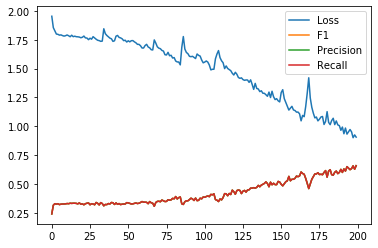

In [172]:
plt.plot(epoch_losses, label="Loss")
plt.plot(epoch_f1_scores, label='F1')
plt.plot(epoch_precision_scores, label="Precision")
plt.plot(epoch_recall_scores, label="Recall")
plt.legend()

In [180]:
# Evaluate
gcn_net.eval()
test_loss = 0

preds = []
labs = []
for i, (bg, labels) in enumerate(test_loader):
    labels = labels.to(device)
    graph_feats = bg.ndata.pop('h').to(device)
    graph_feats, labels = graph_feats.to(device), labels.to(device)
    y_pred = gcn_net(bg, graph_feats)

    preds.append(y_pred.detach().numpy())
    labs.append(labels.detach().numpy())

labs = np.vstack(labs)
preds = np.vstack(preds)

f1 = f1_score(np.argmax(labs, axis=1), np.argmax(preds, axis=1), average='micro')
precision = precision_score(np.argmax(labs, axis=1), np.argmax(preds, axis=1), average='micro')
recall = recall_score(np.argmax(labs, axis=1), np.argmax(preds, axis=1), average='micro')

print(f"TEST F1: {f1:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}")

TEST F1: 0.201, Precision: 0.201, Recall: 0.201
